# 使用numpy实现简单的全连接神经网络 并在mnist数据集上进行测试

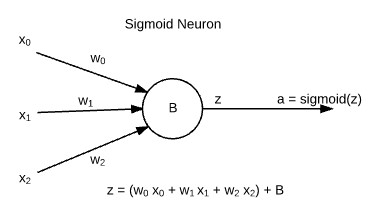

### 1.前向传播算法
将上一层的输出作为下一层的输入，并计算下一层的输出，一直到输出层为止
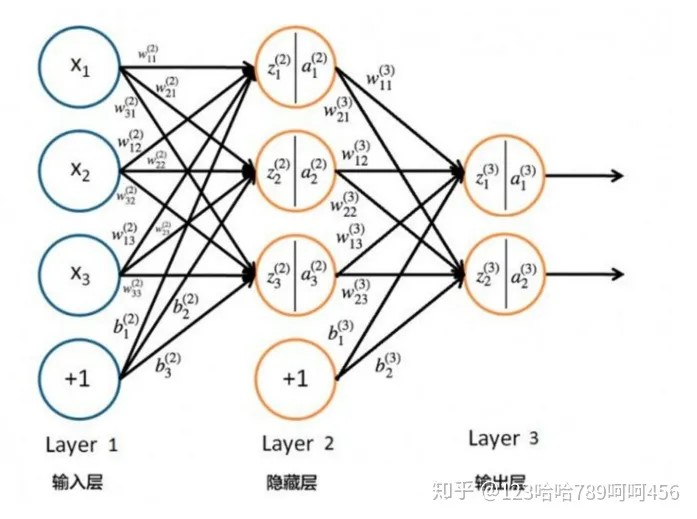
(图片源自网络)
使用矩阵表示

$z^{(l)} = w^{(l)}a^{(l-1)} + b^{(l)}$

$a^{(l)} = \sigma(z^{(l)})$

### 2.反向传播算法
记损失函数为 `L = C(W, b)` 

我们的目标是求 
$\frac{\partial L}{\partial w^{(l)}}$ 和 $\frac{\partial L}{\partial b^{(l)}}$

根据链式法则，可以求出输出层的梯度

$\frac{\partial L}{\partial w^{(l)}} = \frac{\partial L}{\partial a^{(l)}} \frac{\partial a^{(l)}}{\partial z^{(l)}} \frac{\partial z^{(l)}}{\partial w^{(l)}} = \frac{\partial L}{\partial a^{(l)}} \frac{\partial a^{(l)}}{\partial z^{(l)}} a^{(l-1)}$

$\frac{\partial L}{\partial b^{(l)}} = \frac{\partial L}{\partial a^{(l)}} \frac{\partial a^{(l)}}{\partial z^{(l)}} \frac{\partial z^{(l)}}{\partial b^{(l)}} = \frac{\partial L}{\partial a^{(l)}} \frac{\partial a^{(l)}}{\partial z^{(l)}}$

记$\delta^{(l)} = \frac{\partial L}{\partial a^{(l)}} \frac{\partial a^{(l)}}{\partial z^{(l)}}$
  
则隐藏层的梯度

$\delta^{(l)} = \frac{\partial L}{\partial z^{(l+1)}} \frac{\partial z^{(l+1)}}{\partial z^{(l)}} = \delta^{(l+1)} \frac{\partial z^{(l+1)}}{\partial z^{(l)}}$

又由
$z^{(l+1)} = w^{(l+1)} \sigma(z^{(l)}) + b^{(l+1)}$ 
得到
$\frac{\partial z^{(l+1)}}{\partial z^{(l)}} = (w^{(l+1)})^T\odot\sigma'(z^{(l)})$

因此
$\delta^{(l)} = \delta^{(l+1)} (w^{(l+1)})^T\odot\sigma'(z^{(l)})$


由$\delta^{(l)}$的递推关系式，可以很容易的求解$w^{(l)} b^{(l)}$的梯度

$\frac{\partial L}{\partial w^{(l)}} = \delta^{(l)}a^{(l-1)}$

$\frac{\partial L}{\partial b^{(l)}} = \delta^{(l)}$

## 代码实现

引入需要的库

In [6]:
import numpy as np
import pandas as pd

定义损失函数和激活函数

In [2]:
def cross_entropy(y, y_hat):
    return -np.sum(y * np.log(y_hat))

def cross_entropy_gradient(y, y_hat):
    return np.array([yi / (-1.0 * yhati) for yi, yhati in zip(y, y_hat)])      

def mse(y, y_hat):
    return np.sum((y - y_hat) ** 2) / (y.shape[1] * 2.0)

def mse_entropy(y, y_hat):
    return ((y - y_hat) ** 2) * 0.5

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_gradient(x):
    return sigmoid(x) * (1 - sigmoid(x))

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

def softmax_gradient(x):
    return softmax(x) * (1 - softmax(x))

def relu(x):
    return np.maximum(x, 0)

def relu_gradient(x):
    return x > 0


加载数据集函数 注意维度

In [3]:
def load_mnist():
    train_data = pd.read_csv('../dataset/mnist/mnist_train.csv').values
    test_data = pd.read_csv('../dataset/mnist/mnist_test.csv').values

    train_images = train_data[:, 1:]
    train_images = train_images / 255.0
    train_labels_tmp = train_data[:, :1]
    train_images = [i.reshape(-1, 1) for i in train_images]
    train_labels = np.zeros((len(train_labels_tmp), 10))
    for i in range(len(train_labels_tmp)):
        train_labels[i][train_labels_tmp[i]] = 1
    train_labels = np.array([i.reshape(-1, 1) for i in train_labels])

    test_images = test_data[:, 1:]
    test_images = test_images / 255.0
    test_labels_tmp = test_data[:, :1]
    test_images = [i.reshape(-1, 1) for i in test_images]
    test_labels = np.zeros((len(test_labels_tmp), 10))
    for i in range(len(test_labels_tmp)):
        test_labels[i][test_labels_tmp[i]] = 1
    test_labels = np.array([i.reshape(-1, 1) for i in test_labels])

    return train_images, train_labels, test_images, test_labels

In [9]:
class NeuralNetwork:
    def __init__(self, layers, learning_rate, mini_batch_size, activation, loss):
        self.layers = layers
        self.learning_rate = learning_rate
        self.mini_batch_size = mini_batch_size
        self.num_layers = len(layers)
        self.activation_fn = {}
        self.activation_gradient = {}
        
        if loss == 'cross_entropy':
            self.loss = cross_entropy
            self.loss_gradient = cross_entropy_gradient
        elif loss == 'mse':
            self.loss = mse
            self.loss_gradient = mse_gradient

        for i, a in enumerate(activation):
            if a == 'sigmoid':
                self.activation_fn[i + 1] = sigmoid
                self.activation_gradient[i + 1] = sigmoid_gradient
            elif a == 'relu':
                self.activation_fn[i + 1] = relu
                self.activation_gradient[i + 1] = relu_gradient
            elif a == 'softmax':
                self.activation_fn[i + 1] = softmax
                self.activation_gradient[i + 1] = softmax_gradient

        self.weights = [np.array([0])] + [np.random.randn(y, x) / np.sqrt(x) for y, x in zip(layers[1:], layers[:-1])]
        self.biases = [np.array([0])] + [np.random.randn(y, 1) for y in layers[1:]]
        
        self._zs = [np.zeros((bias.shape)) for bias in self.biases] # z = w * a + b
        self._activations = [np.zeros((bias.shape)) for bias in self.biases] # a = f(z)

    def forward(self, x):
        self._activations[0] = x
        for i in range(1, self.num_layers):
            self._zs[i] = self.weights[i] @ self._activations[i - 1] + self.biases[i]

            self._activations[i] = self.activation_fn[i](self._zs[i])

    def backward(self, y):
        nabla_b = [np.zeros((bias.shape)) for bias in self.biases]
        nabla_w = [np.zeros((weight.shape)) for weight in self.weights]

        # softmax + mse
        # delta = self.loss_gradient(y, self._activations[-1]) * self.activation_gradient[self.num_layers - 1](self._zs[-1])

        # softmax + cross entropy
        # delta = self._activations[-1] - y

        # delta = self.loss_gradient(y, self._activations[-1]) * self.activation_gradient[self.num_layers - 1](self._zs[-1])
        # TODO: automatically calculate delta of the last layer
        delta = self._activations[-1] - y
        nabla_b[-1] = delta
        nabla_w[-1] = delta @ self._activations[-2].T

        for i in range(self.num_layers - 2, 0, -1):
            delta = self.weights[i + 1].T @ delta * self.activation_gradient[i](self._zs[i])
            nabla_b[i] = delta
            nabla_w[i] = delta @ self._activations[i - 1].T

        return nabla_b, nabla_w
    
    def train(self, training_data, training_label, validation_data, validation_label, epochs = 10):
        loss_history = []
        for epoch in range(epochs):
            mini_batches = [
                list(zip(training_data[k: k + self.mini_batch_size], training_label[k: k + self.mini_batch_size])) for k in range(0, len(training_data), self.mini_batch_size)
            ]

            for mini_batch in mini_batches:
                nabla_b = [np.zeros((bias.shape)) for bias in self.biases]
                nabla_w = [np.zeros((weight.shape)) for weight in self.weights]

                for x, y in mini_batch:
                    self.forward(x)
                    delta_nabla_b, delta_nabla_w = self.backward(y)

                    nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
                    nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]

                self.weights = [w - (self.learning_rate / self.mini_batch_size) * nw for w, nw in zip(self.weights, nabla_w)]
                self.biases = [b - (self.learning_rate / self.mini_batch_size) * nb for b, nb in zip(self.biases, nabla_b)]
            
            pre = self.predict_group(validation_data).reshape(validation_label.shape)
            loss = self.loss(validation_label, pre) / len(validation_data)
            loss_history.append(loss)
            accuracy = [np.argmax(pre) == np.argmax(y) for pre, y in zip(pre, validation_label)].count(True) / len(validation_data)
            print(f'Epoch {epoch}: accuracy: {accuracy} loss = {loss}')
        return loss_history

    def evaluate(self, test_data, test_label):
        results = [np.argmax(self.predict(x)) == np.argmax(y) for x, y in zip(test_data, test_label)]
        return sum(results)

    def predict_group(self, data):
        res = np.array([])
        for x in data:
            res = np.append(res, self.predict(x))
        return res
    
    def predict(self, x):
        self.forward(x)
        return self._activations[-1]
    
    def save(self, path = 'model.npy'):
        np.save(path, [self.weights, self.biases])
    
    def load(self, path = 'model.npy'):
        self.weights, self.biases = np.load(path, allow_pickle=True)

导入数据集

In [7]:
X_train, y_train, X_validation, y_validation = load_mnist()

In [ ]:
layers = [784, 100, 25, 10]
lr = 0.01
mini_batch_size = 100

net = NeuralNetwork(layers, lr, mini_batch_size, ['relu', 'relu', 'softmax'], 'cross_entropy')
loss_history = net.train(X_train, y_train, X_validation, y_validation, 20)

Epoch 0: accuracy: 0.8555 loss = 0.6532446884173885
Epoch 1: accuracy: 0.8826 loss = 0.4523270647753313
Epoch 2: accuracy: 0.8928 loss = 0.3875090269481781
Epoch 3: accuracy: 0.8997 loss = 0.35518347039048376
Epoch 4: accuracy: 0.9034 loss = 0.3353059800716609
Epoch 5: accuracy: 0.907 loss = 0.32135464149697485
Epoch 6: accuracy: 0.9096 loss = 0.31058981061102464
Epoch 7: accuracy: 0.9136 loss = 0.30169893493822514
Epoch 8: accuracy: 0.9166 loss = 0.29412030354847235
Epoch 9: accuracy: 0.9189 loss = 0.2873829007278021
Epoch 10: accuracy: 0.9196 loss = 0.28127349640331306
Epoch 11: accuracy: 0.9207 loss = 0.275541369024024
Epoch 12: accuracy: 0.9222 loss = 0.27010234360142993
Epoch 13: accuracy: 0.9233 loss = 0.26492017011584384


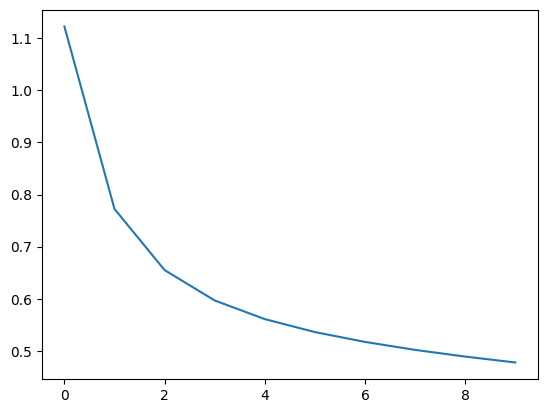

In [7]:
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.show()

识别一个自己手写的数字

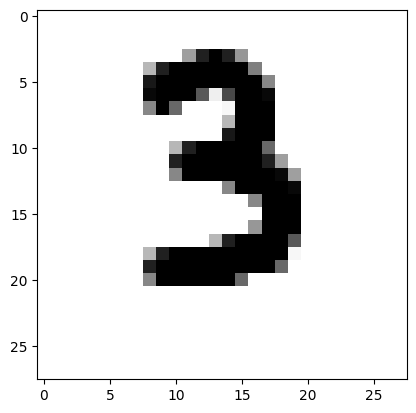

In [57]:
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open('digit.png')
plt.imshow(image)

In [61]:
img = np.dot(np.array(image)[...,:3], [0.299, 0.587, 0.114])
img = 255 - img

np.argmax(net.predict(img.reshape(-1, 1) / 255.0))

3